#Table of Contents
* [Using k=21](#Using-k=21)
	* [Commands for just loading the reference (no diginorm), replaced 'N' with 'A'](#Commands-for-just-loading-the-reference-%28no-diginorm%29,-replaced-'N'-with-'A')
	* [Check alignment quality](#Check-alignment-quality)
		* [Bonus: I broke the readaligner!](#Bonus:-I-broke-the-readaligner!)
	* [Loading reads and aligning the reference to it](#Loading-reads-and-aligning-the-reference-to-it)
* [Using k=13](#Using-k=13)
	* [Loading ref to graph](#Loading-ref-to-graph)
	* [Load moleculo to graph](#Load-moleculo-to-graph)
	* [Aligning PacBio to moleculo graph](#Aligning-PacBio-to-moleculo-graph)
	* [Aligning PacBio to galGal4 graph](#Aligning-PacBio-to-galGal4-graph)
	* [Aligning galGal4 to PacBio graph](#Aligning-galGal4-to-PacBio-graph)
	* [Comparing moleculo and PacBio as graphs, galGal4 as query](#Comparing-moleculo-and-PacBio-as-graphs,-galGal4-as-query)
* [Training](#Training)
	* [Problems](#Problems)


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from screed.fastq import fastq_iter
import gzip

# Using k=21

- Run `normalize-by-median.py` with cutoff = 1 on the reference
   * The ecoli example load reads into counting table and then maps the reference to it. I started through the same route with PacBio, but it required too much memory (I'll try again on HPCC). From the email I understood I should load the reference and then map the reads, but a part of the reference is discarded during diginorm.
   * No need to do this, actually cutoff was the trusted parameter on the aligner...
- Load the reference into counting table
- Used as much memory I had available on the node I was running it (~28G)
- I modified `find-variant-by-align-long.py` to only output the header of each alignment.

- There are many 'N' and soft-clipped sequences in the reference. Is this an issue?
   * Yes, it is. Replaced all 'N' with 'A' on a new file, 'galGal4.fixed.fa.gz'

In [43]:
bases_in_galGal4 = 1046932099

## Commands for just loading the reference (no diginorm), replaced 'N' with 'A'

In [47]:
!cd ../2015-khmer-wok2-vc && make -Bn galGal4.fixed.align.out

wget -SNc ftp://hgdownload.cse.ucsc.edu/goldenPath/galGal4/bigZips/galGal4.fa.gz
python fix_reference.py galGal4.fa.gz galGal4.fixed.fa.gz
load-into-counting.py -k 21 -N 6 -x 2.5e9 galGal4.fixed.k21.kh galGal4.fixed.fa.gz
../2015-experimental-graphalign/find-variant-by-align-long.py --trusted 1 galGal4.fixed.k21.kh /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead.fastq.gz --variants-out variants-galGal4-fixed.txt > galGal4.fixed.align.out


In [48]:
!ls -sh ../2015-khmer-wok2-vc/galGal4.fixed.k21.kh
!cat ../2015-khmer-wok2-vc/galGal4.fixed.k21.kh.info

0 ../2015-khmer-wok2-vc/galGal4.fixed.k21.kh
cat: ../2015-khmer-wok2-vc/galGal4.fixed.k21.kh.info: No such file or directory


## Check alignment quality

- It's attrocious. Not really, I was just running it wrong. Using `--trusted 1` alignments are actually very good!

In [49]:
def check_align(align_out, ranges=[(0, 10), (0, 1, .1)], graph="galGal4", query="moleculo"):
    reads = {}

    with open(align_out, 'r') as f:
        for line in f:
            if '%' in line:
                name, start, end, span, percent = line.strip().split()
                reads[name] = {'start': int(start), 'end': int(end), 'span': int(span), 'percent': float(percent[:-1])}

    data = pd.DataFrame.from_dict(reads).T
    
    plt.figure()
    plt.title("Graph: {0}\nQuery: {1}".format(graph, query))
    plt.xlabel("% of the query's longest span aligned to graph")
    plt.ylabel("Number of query sequences")
    plt.xlim(0, 100)
    data['percent'].hist(bins=np.linspace(0, 100, 11))
    data['percent'].hist(bins=np.linspace(*ranges[0]))

    plt.figure()
    plt.title("Graph: {0}\nQuery: {1}".format(graph, query))
    plt.xlabel("% of the query's longest span aligned to graph")
    plt.ylabel("Number of query sequences")
    plt.xlim(ranges[0][0], 100)
    data['percent'].hist(bins=np.linspace(*ranges[0]))
    data['percent'].hist(bins=np.linspace(*ranges[1]))
    
    return data

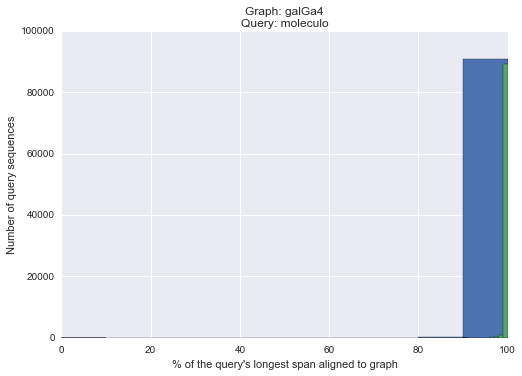

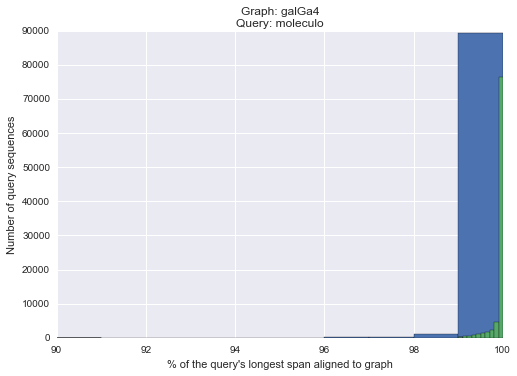

In [18]:
galGal4_k21 = check_align('../2015-khmer-wok2-vc/galGal4.fixed.align.out',
                          ranges=[(90, 100, 11), (99, 100, 11)],
                          graph="galGa4",
                          query="moleculo")

In [10]:
galGal4_k21[galGal4_k21['percent'] > 90].count()

end        90808
percent    90808
span       90808
start      90808
dtype: int64

In [11]:
galGal4_k21.sort('span', ascending=False).head(10)

,end,percent,span,start
Read_47161-Barcode=BC086-PIPELINE=Develop_T40,8626,2.017,8452,174
Read_71097-Barcode=BC131-PIPELINE=Develop_T40,8034,4.630,7662,372
Read_38590-Barcode=BC071-PIPELINE=Develop_T40,7533,1.858,7393,140
Read_46369-Barcode=BC085-PIPELINE=Develop_T40,8255,12.707,7206,1049
Read_24604-Barcode=BC046-PIPELINE=Develop_T40,8037,29.737,5647,2390
Read_32528-Barcode=BC061-PIPELINE=Develop_T40,10015,46.980,5310,4705
Read_38353-Barcode=BC071-PIPELINE=Develop_T40,6515,24.574,4914,1601
Read_65178-Barcode=BC120-PIPELINE=Develop_T40,4555,1.493,4487,68
Read_25574-Barcode=BC048-PIPELINE=Develop_T40,7410,43.293,4202,3208
Read_5729-Barcode=BC011-PIPELINE=Develop_T40,6373,34.819,4154,2219


In [59]:
bases_mapped = galGal4_k21['span'].sum()
bases_mapped

717135.0

In [60]:
bases_mapped / bases_in_galGal4

0.00068498711681969353

### Bonus: I broke the readaligner!

`find-variant-by-align-long.py` segfaulted, memory consumption slowly but steadily increases (about half the moleculo reads were processed for the previous figures).

This problem was fixed by decrementing the refcount in align_forward, which was leaking memory.

## Loading reads and aligning the reference to it

- Used QP's functions to find the approximate memory needed (after counting unique kmers with HLL).
   * Estimated unique kmers: 904.369.109
   * Expected error rate: 0.01
   * Calculated parameters:
     - Number of tables: 6
     - Memory per table: 2e9
- Tested with `--trusted 5`
- There are ~15k contigs in galGal4, more than 10k align >90%
- <span style="color:red">Needs attention</span>: I was considering 'percent' for check if it was working, but it means something different than I expected: "percent matched" means "percent of the span matched", where span doesn't imply start to end of read.

In [50]:
!cd ../2015-khmer-wok2-vc && make -Bn moleculo.align.out

load-into-counting.py -k 21 -N 6 -x 2e9 moleculo.k21.kh /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead_500_1499nt.fastq.gz /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead.fastq.gz /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-2_LongRead_500_1499nt.fastq.gz /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-2_LongRead.fastq.gz /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-3_LongRead_500_1499nt.fastq.gz /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-3_LongRead.fastq.gz /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-4_LongRead_500_1499nt.fastq.gz /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-4_LongRead.fastq.gz /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-5_LongRead_500_1499nt.fastq.gz /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-5_LongRead.fastq.gz
wget -SNc ftp://hgdownload.cse.ucsc.edu/goldenPath/galGal4/bigZips/galGal4.fa.gz
python fix_referen

In [53]:
!ls -sh ../2015-khmer-wok2-vc/moleculo.k21.kh
!cat ../2015-khmer-wok2-vc/moleculo.k21.kh.info

12G ../2015-khmer-wok2-vc/moleculo.k21.kh
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead_500_1499nt.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-2_LongRead_500_1499nt.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-2_LongRead.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-3_LongRead_500_1499nt.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-3_LongRead.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-4_LongRead_500_1499nt.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-4_LongRead.fastq.gz
through /mnt/research/ged/irberlui

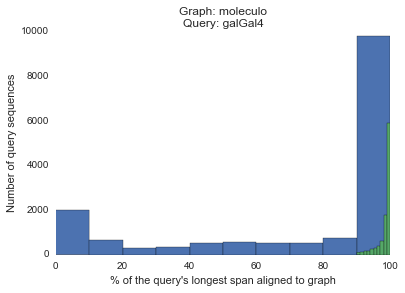

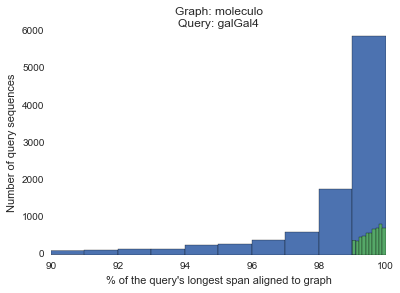

In [55]:
moleculo_k21 = (check_align('../2015-khmer-wok2-vc/moleculo.align.out',
                                  ranges=[(90, 100, 11), (99, 100, 11)],
                                  graph="moleculo",
                                  query="galGal4")
                       .query('span != 0'))

In [56]:
moleculo_k21[moleculo_k21['percent'] > 90].count()

end        9799
percent    9799
span       9799
start      9799
dtype: int64

In [57]:
moleculo_k21.sort('span', ascending=False).head(20)

,end,percent,span,start
chr1,195284953,86.874,25632877,169652076
chrZ,82367875,71.042,23851812,58516063
chr2,148816091,87.133,19147781,129668310
chr3,110451292,86.989,14370922,96080370
chr4,90219931,85.835,12779290,77440641
chr5,59582583,84.961,8960409,50622174
chr7,36246061,85.985,5079957,31166104
chr6,34952711,85.929,4918052,30034659
chr8,28768056,84.042,4590887,24177169
chr9,23442432,84.404,3656106,19786326


In [58]:
bases_mapped = moleculo_k21['span'].sum()
bases_mapped

175847484.0

In [59]:
bases_mapped / bases_in_galGal4

0.1679645548817966

# Using k=13

## Loading ref to graph

In [60]:
!cd ../2015-khmer-wok2-vc && make -Bn galGal4.fixed.k13.align.out

wget -SNc ftp://hgdownload.cse.ucsc.edu/goldenPath/galGal4/bigZips/galGal4.fa.gz
python fix_reference.py galGal4.fa.gz galGal4.fixed.fa.gz
load-into-counting.py -k 13 -N 6 -x 5e7 galGal4.fixed.k13.kh galGal4.fixed.fa.gz
../2015-experimental-graphalign/find-variant-by-align-long.py --trusted 1 galGal4.fixed.k13.kh /home/chick/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead.fastq.gz --variants-out variants-galGal4-fixed.txt > galGal4.fixed.k13.align.out


In [62]:
!ls -sh ../2015-khmer-wok2-vc/galGal4.fixed.k13.kh
!cat ../2015-khmer-wok2-vc/galGal4.fixed.k13.kh.info

289M ../2015-khmer-wok2-vc/galGal4.fixed.k13.kh
through galGal4.fixed.fa.gz
fp rate estimated to be 0.042



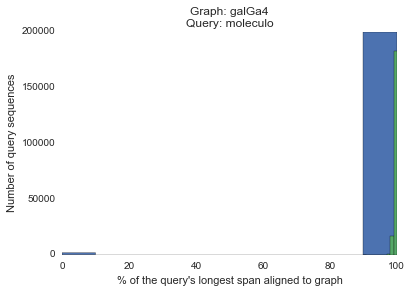

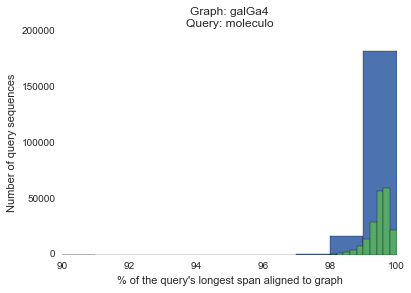

In [65]:
galGal4_k13 = (check_align('../2015-khmer-wok2-vc/galGal4.fixed.k13.align.out',
                          ranges=[(90, 100, 11), (98, 100, 11)],
                          graph="galGa4",
                          query="moleculo")
               .query('span != 0'))

In [70]:
galGal4_k13[galGal4_k13['percent'] > 90].count()

end        199982
percent    199982
span       199982
start      199982
dtype: int64

In [71]:
galGal4_k13.sort('span', ascending=False).head(10)

,end,percent,span,start
Read_161742-Barcode=BC306-PIPELINE=Develop_T40,8685,95.797,365,8320
Read_71097-Barcode=BC131-PIPELINE=Develop_T40,8034,97.772,179,7855
Read_47161-Barcode=BC086-PIPELINE=Develop_T40,8626,98.354,142,8484
Read_152771-Barcode=BC288-PIPELINE=Develop_T40,10553,98.929,113,10440
Read_32528-Barcode=BC061-PIPELINE=Develop_T40,10012,98.891,111,9901
Read_38590-Barcode=BC071-PIPELINE=Develop_T40,7533,98.566,108,7425
Read_84214-Barcode=BC157-PIPELINE=Develop_T40,9065,98.820,107,8958
Read_16174-Barcode=BC031-PIPELINE=Develop_T40,10026,98.933,107,9919
Read_158314-Barcode=BC299-PIPELINE=Develop_T40,10875,99.034,105,10770
Read_107859-Barcode=BC202-PIPELINE=Develop_T40,11259,99.076,104,11155


In [72]:
bases_mapped = galGal4_k13['span'].sum()
bases_mapped

5113009.0

In [73]:
bases_mapped / bases_in_galGal4

0.0048838019245792562

## Load moleculo to graph

In [49]:
!cd ../2015-khmer-wok2-vc && make -Bn moleculo.k13.align.out

load-into-counting.py -k 13 -N 6 -x 5e7 moleculo.k13.kh /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead_500_1499nt.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-2_LongRead_500_1499nt.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-2_LongRead.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-3_LongRead_500_1499nt.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-3_LongRead.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-4_LongRead_500_1499nt.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-4_LongRead.fastq.gz /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-5_

In [50]:
!ls -sh ../2015-khmer-wok2-vc/moleculo.k13.kh
!cat ../2015-khmer-wok2-vc/moleculo.k13.kh.info

280M ../2015-khmer-wok2-vc/moleculo.k13.kh
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead_500_1499nt.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-1_LongRead.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-2_LongRead_500_1499nt.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-2_LongRead.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-3_LongRead_500_1499nt.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-3_LongRead.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-4_LongRead_500_1499nt.fastq.gz
through /mnt/research/ged/irberlui/biodata/galGal/inputs/moleculo/LR6000017-DNA_A01-LRAAA-4_LongRead.fastq.gz
through /mnt/research/ged/irberlu

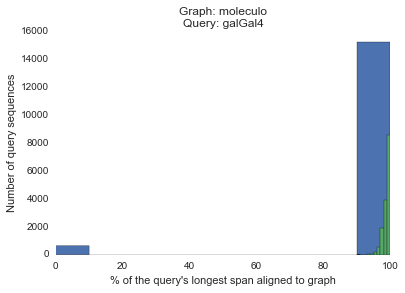

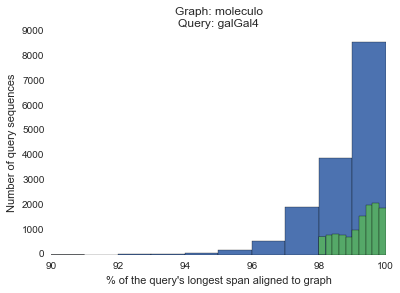

In [74]:
moleculo_k13 = (check_align('../2015-khmer-wok2-vc/moleculo.k13.align.out',
                           ranges=[(90, 100, 11), (98, 100, 11)],
                           graph="moleculo",
                           query="galGal4")
                .query('span != 0'))

In [75]:
moleculo_k13[moleculo_k13['percent'] > 90].count()

end        15285
percent    15285
span       15285
start      15285
dtype: int64

In [76]:
moleculo_k13.sort('span', ascending=False).head(20)

,end,percent,span,start
chr1,195277456,99.541,897148,194380308
chr2,148810343,99.537,688344,148121999
chr3,110448236,99.536,512966,109935270
chrZ,82364065,99.471,436047,81928018
chr4,90217241,99.523,430001,89787240
chr5,59580772,99.498,299199,59281573
chr7,36245288,99.499,181615,36063673
chr6,34951876,99.504,173306,34778570
chr8,28767456,99.475,150979,28616477
chr9,23441905,99.471,123908,23317997


In [77]:
bases_mapped = moleculo_k13['span'].sum()
bases_mapped

5478913.0

In [78]:
bases_mapped / bases_in_galGal4

0.0052333031007773126

## Aligning PacBio to moleculo graph

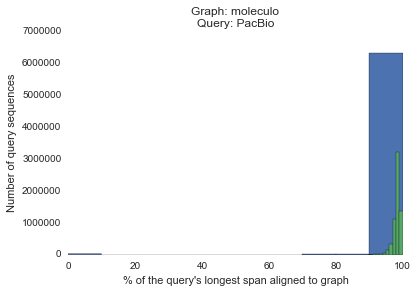

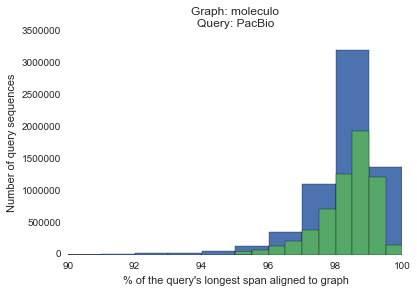

In [113]:
moleculo_k13_pacbio = (check_align('../2015-khmer-wok2-vc/moleculo.k13.align.pacbio',
                                  ranges=[(90, 100, 11), (95, 100, 11)],
                                  graph="moleculo",
                                  query="PacBio")
                       .query('span != 0'))

In [114]:
moleculo_k13_pacbio[moleculo_k13_pacbio['percent'] > 90].count()

end        6319956
percent    6319956
span       6319956
start      6319956
dtype: int64

In [115]:
moleculo_k13_pacbio.sort('span', ascending=False).head(20)

,end,percent,span,start
m141113_041345_00116_c100718302550000001823144805141582_s1_p0/104551/1693_26111,24439,92.041,1945,22494
m141113_171124_00116_c100718302550000001823144805141585_s1_p0/82256/1658_26566,24931,93.229,1688,23243
m141126_010828_00116_c100676372550000001823144002221546_s1_p0/51552/1810_23402,21616,92.598,1600,20016
m140626_085306_00116_c100661912550000001823125811271484_s1_p0/16982/0_21206,21221,92.639,1562,19659
m141204_210548_00116_c100686412550000001823135002281586_s1_p0/119934/0_22558,22571,93.190,1537,21034
m141114_015447_00116_c100718302550000001823144805141587_s1_p0/24474/0_38479,38485,96.027,1529,36956
m141113_171124_00116_c100718302550000001823144805141585_s1_p0/91513/2562_22622,20079,92.410,1524,18555
m140626_053156_00116_c100661912550000001823125811271483_s1_p0/109160/0_18912,18928,91.959,1522,17406
m141125_120659_00116_c100676372550000001823144002221543_s1_p0/161033/0_21613,21626,93.032,1507,20119
m141120_044828_00116_c100698992550000001823142903261562_s1_p0/61048/0_19359,19373,92.293,1493,17880


In [116]:
bases_mapped = moleculo_k13_pacbio['span'].sum()
bases_mapped

513894604.0

In [117]:
bases_mapped / bases_in_galGal4

0.49085762533296823

## Aligning PacBio to galGal4 graph

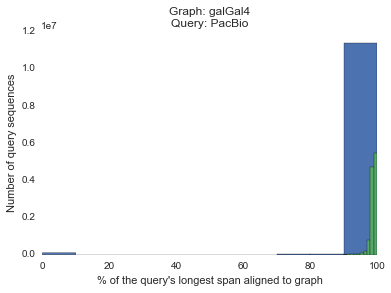

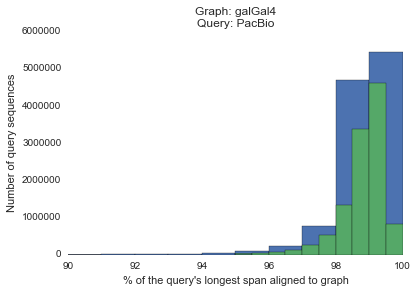

In [118]:
galGal4_k13_pacbio = (check_align('../2015-khmer-wok2-vc/galGal4.fixed.k13.align.pacbio',
                                  ranges=[(90, 100, 11), (95, 100, 11)],
                                  graph="galGal4",
                                  query="PacBio")
                       .query('span != 0'))

In [119]:
galGal4_k13_pacbio[galGal4_k13_pacbio['percent'] > 90].count()

end        11387949
percent    11387949
span       11387949
start      11387949
dtype: int64

In [120]:
galGal4_k13_pacbio.sort('span', ascending=False).head(20)

,end,percent,span,start
m140625_193459_00116_c100661912550000001823125811271480_s1_p0/57115/0_24428,24450,94.699,1296,23154
m140626_085306_00116_c100661912550000001823125811271484_s1_p0/16982/0_21206,21215,94.584,1149,20066
m141114_015447_00116_c100718302550000001823144805141587_s1_p0/24474/0_38479,38486,97.209,1074,37412
m141119_201023_00116_c100698992550000001823142903261560_s1_p0/110780/369_23468,23104,95.364,1071,22033
m140626_053156_00116_c100661912550000001823125811271483_s1_p0/25767/0_18173,18179,94.109,1071,17108
m140626_053156_00116_c100661912550000001823125811271483_s1_p0/59366/0_23085,23091,95.461,1048,22043
m141126_010828_00116_c100676372550000001823144002221546_s1_p0/55087/0_23229,23238,95.744,989,22249
m141126_010828_00116_c100676372550000001823144002221546_s1_p0/61768/0_26040,26043,96.291,966,25077
m140626_185518_00116_c100661912550000001823125811271487_s1_p0/152966/0_22736,22741,95.853,943,21798
m141207_022214_00116_c100681682550000001823133202281567_s1_p0/9379/870_33123,32254,97.079,942,31312


In [121]:
bases_mapped = galGal4_k13_pacbio['span'].sum()
bases_mapped

648494710.0

In [122]:
bases_mapped / bases_in_galGal4

0.61942384861389177

## Aligning galGal4 to PacBio graph

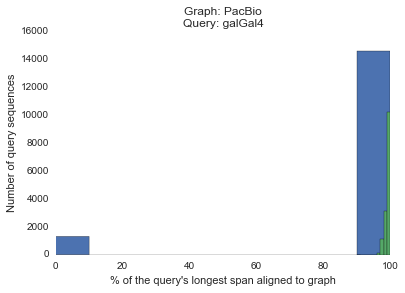

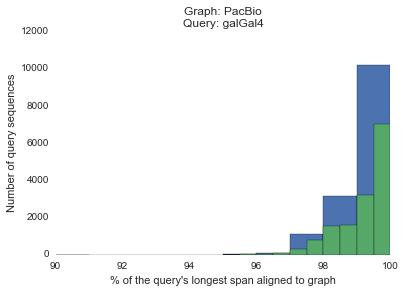

In [123]:
pacbio_k13_galGal4 = (check_align('../2015-khmer-wok2-vc/pacbio.k13.align.ref',
                                  ranges=[(90, 100, 11), (95, 100, 11)],
                                  graph="PacBio",
                                  query="galGal4")
                       .query('span != 0'))

In [124]:
pacbio_k13_galGal4[pacbio_k13_galGal4['percent'] > 90].count()

end        14618
percent    14618
span       14618
start      14618
dtype: int64

In [125]:
pacbio_k13_galGal4.sort('span', ascending=False).head(20)

,end,percent,span,start
chr1,195276750,99.606,770336,194506414
chr2,148809762,99.603,590706,148219056
chr3,110447801,99.602,439895,110007906
chr4,90216835,99.602,359222,89857613
chrZ,82363669,99.604,326333,82037336
chr5,59580361,99.606,234536,59345825
chr7,36245040,99.605,143111,36101929
chr6,34951654,99.614,134916,34816738
chr8,28767244,99.608,112885,28654359
chr9,23441680,99.612,90992,23350688


In [126]:
bases_mapped = pacbio_k13_galGal4['span'].sum()
bases_mapped

4159867.0

In [127]:
bases_mapped / bases_in_galGal4

0.0039733875806973419

## Comparing moleculo and PacBio as graphs, galGal4 as query

In [182]:
top_mol = moleculo_k13.sort('span', ascending=False).head(20)
top_pacbio = pacbio_k13_galGal4.sort('span', ascending=False).head(20)

In [187]:
(pd.merge(top_mol, top_pacbio, 
         left_index=True, right_index=True, 
         suffixes=('_moleculo', '_pacbio'))
 [['span_moleculo', 'span_pacbio', 'percent_moleculo', 'percent_pacbio']])

,span_moleculo,span_pacbio,percent_moleculo,percent_pacbio
chr1,897148,770336,99.541,99.606
chr2,688344,590706,99.537,99.603
chr3,512966,439895,99.536,99.602
chr4,430001,359222,99.523,99.602
chrZ,436047,326333,99.471,99.604
chr5,299199,234536,99.498,99.606
chr7,181615,143111,99.499,99.605
chr6,173306,134916,99.504,99.614
chr8,150979,112885,99.475,99.608
chr9,123908,90992,99.471,99.612


# Training

- K=21
 - Reference: galGal4
 - Query: galGal4.LR6000017-DNA_A01-LRAAA-AllReads.sorted.bam (previously mapped with bwa-mem)

## Problems

- galGal4 has 'N' and soft-clipped regions. Training script not ready for this in CIGAR:
   ```python
   >>> cigar_to_state
   {0: 'M', 1: 'Ir', 2: 'Ig'}
   >>> rec.cigarstring
   '251S638M1I16M'
   ```
   Does it make sense to support other fields, or should I clean up the reference first? (From http://davetang.org/wiki/tiki-index.php?page=SAM )

| op | Description                                                    |
|----|----------------------------------------------------------------|
| M	 | Alignment match (can be a sequence match or mismatch           |
| I	 | Insertion to the reference                                     |
| D	 | Deletion from the reference                                    |
| N	 | Skipped region from the reference                              |
| S	 | Soft clip on the read (clipped sequence present in <seq>)      |
| H	 | Hard clip on the read (clipped sequence NOT present in <seq>)  |
| P	 | Padding (silent deletion from the padded reference sequence)   |